In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import PIL.Image
from tensorflow.keras import layers, models

Test and configure GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else:
    print('No GPUs detected')

No GPUs detected


In [3]:
tf.config.list_physical_devices('GPU')

[]

In [4]:
meta_path = "cov_data/metadata.csv"
data_path = "cov_data"

In [5]:
metadata = pd.read_csv(meta_path,delimiter=',',names=['fn','class'],skiprows=1)
metadata[:5]

,fn,class
0,covid/COVID19(308).jpg,1
1,covid/COVID-19 (839).jpg,1
2,covid/COVID-19 (105).jpg,1
3,covid/COVID-19 (379).jpg,1
4,covid/COVID19(443).jpg,1


Can discard metadata? Labels are determined by folders (covid/pneum/normal).
Can try merging normal and pneum.

In [16]:
def load_data_tf(data_path: str, img_shape=(256,256), batch_size: int=64):
    train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
        data_path,
        validation_split=0.2,
        subset="both",
        label_mode='categorical',
        seed=123,
        image_size=img_shape,
        batch_size=batch_size)
    return train_ds, val_ds

In [17]:
train_ds, val_ds = load_data_tf('cov_data')

Found 4575 files belonging to 3 classes.
Using 3660 files for training.
Using 915 files for validation.


tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)


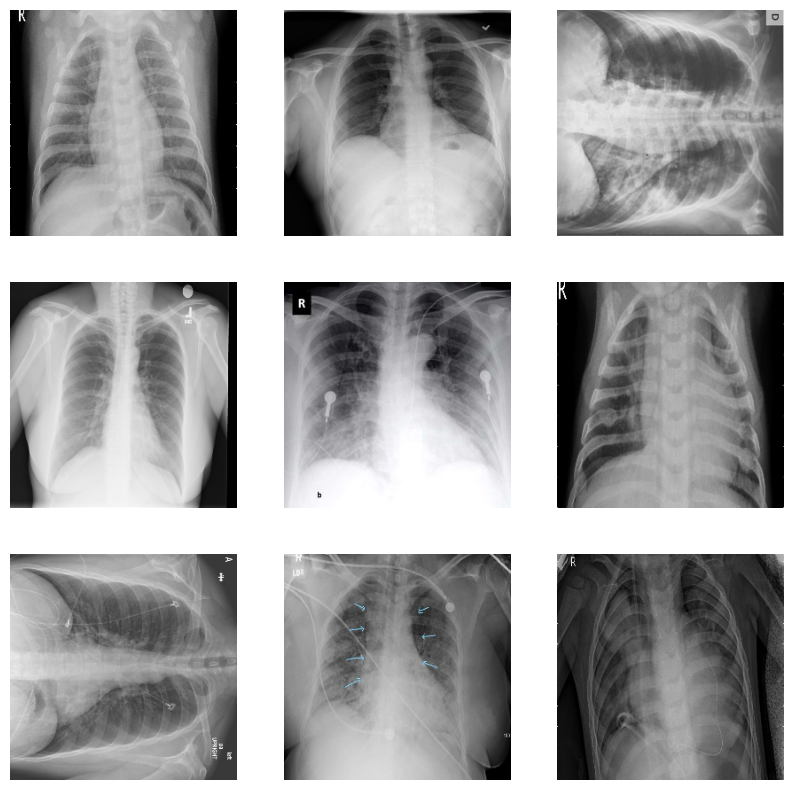

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    # plt.title(train_ds.class_names[labels[i]])
    print(labels[i])
    plt.axis("off")

In [17]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 256, 256, 3)
(64, 3)


In [18]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

THE ATTENTION MODEL. HANDLE WITH CARE - MAY CAUSE COMPUTER TO EXPLODE VIOLENTLY

In [19]:
from keras import backend as K

# ATTENTION MODEL

''' FIRST CONV BLOCK '''
l_input = layers.Input(shape=(256,256,3))
l_norm = tf.keras.layers.Rescaling(1./255) (l_input)
conv_1_1 = layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same', name='conv_1_1') (l_norm)
bn_1_1 = layers.BatchNormalization() (conv_1_1)
conv_1_2 = layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',padding='same', name='conv_1_2') (bn_1_1)
bn_1_2 = layers.BatchNormalization() (conv_1_2)
drop_1 = layers.Dropout(rate=0.2, name='drop_1') (bn_1_2)

# this gets passed on to the attention mechanism
l_dense_con_1 = layers.Dense(units=64, activation=None,name='conn_1')(drop_1)

pool_1 = layers.MaxPooling2D(pool_size=(2,2),name='pool_1') (drop_1)

''' SECOND CONV BLOCK '''
conv_2_1 = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same', name='conv_2_1') (pool_1)
bn_2_1 = layers.BatchNormalization() (conv_2_1)
conv_2_2 = layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same', name='conv_2_2') (bn_2_1)
bn_2_2 = layers.BatchNormalization() (conv_2_2)
drop_2 = layers.Dropout(rate=0.2,name='drop_2') (bn_2_2)

l_dense_con_2 = layers.Dense(units=64, activation=None,name='conn_2')(drop_2)

pool_2 = layers.MaxPooling2D(pool_size=(2,2),name='pool_2') (drop_2)

''' THIRD CONV BLOCK '''
conv_3_1 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv_3_1') (pool_2)
bn_3_1 = layers.BatchNormalization() (conv_3_1)
conv_3_2 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv_3_2') (bn_3_1)
bn_3_2 = layers.BatchNormalization() (conv_3_2)
drop_3 = layers.Dropout(rate=0.2,name='drop_3') (bn_3_2)

l_dense_con_3 = layers.Dense(units=64, activation=None,name='conn_3')(drop_3)

pool_3 = layers.MaxPooling2D(pool_size=(2,2),name='pool_3') (drop_3)

''' FINAL CONV BLOCK, GIVES THE FINAL REPRESENTATION (g) '''
conv_4_1 = layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same',name='conv_4_1') (pool_3)
bn_4_1 = layers.BatchNormalization() (conv_4_1)
pool_4_2 = layers.MaxPooling2D(pool_size=(2,2),name='pool_4_2') (bn_4_1)

flat_g = layers.Flatten(name='flat_g') (pool_4_2)
drop_g = layers.Dropout(rate=0.4,name='drop_g') (flat_g)
g = layers.Dense(units=64,activation='relu',name='g') (drop_g)

""" Calculate compatibility scores """
# dot product of l_i's and g
c_1 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3), name='cdp1')([l_dense_con_1, g])
flat_1 = layers.Flatten() (c_1)
act_1 = layers.Softmax() (flat_1)
c_2 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3), name='cdp2')([l_dense_con_2, g])
flat_2 = layers.Flatten() (c_2)
act_2 = layers.Softmax() (flat_2)
c_3 = layers.Lambda(lambda lam: K.squeeze(K.map_fn(fn=lambda xy: K.dot(xy[0], xy[1]), elems=(lam[0], K.expand_dims(lam[1], -1)), dtype=tf.float32), 3), name='cdp3')([l_dense_con_3, g])
flat_3 = layers.Flatten() (c_3)
act_3 = layers.Softmax() (flat_3)

rs_1 = layers.Reshape((-1,64)) (l_dense_con_1)
g_a_1 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga1')([act_1,rs_1])

rs_2 = layers.Reshape((-1,64)) (l_dense_con_2)
g_a_2 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga2')([act_2,rs_2])

rs_3 = layers.Reshape((-1,64)) (l_dense_con_3)
g_a_3 = layers.Lambda(lambda lam: K.squeeze(K.batch_dot(K.expand_dims(lam[0], 1), lam[1]), 1), 
             name='ga3')([act_3,rs_3])

l_concat = layers.Concatenate() ([g_a_1, g_a_2, g_a_3]) # concatenate the three attention outputs
l_dense_out = layers.Dense(units = 3, activation='softmax') (l_concat)

model_att = models.Model(inputs=l_input, outputs=l_dense_out)
model_att.save_weights('model_att_init_weights.h5')

model_att.summary()
tf.keras.utils.plot_model(model_att, 'model_att.png', show_shapes=True)

Instructions for updating:
Use fn_output_signature instead
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 256, 256, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv_1_1 (Conv2D)           (None, 256, 256, 16)         448       ['rescaling[0][0]']           
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv_1_1[0][0]']            
 Normalization)                    

In [20]:
model_att.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [19]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=4)

history_att = model_att.fit(train_ds, epochs=50, callbacks=callback,
                    validation_data=val_ds) 

NameError: name 'model_att' is not defined

In [10]:
model = models.Sequential()
model.add(layers.Conv2D(filters=16,kernel_size=(3,3),activation='relu',input_shape=(256,256,3)))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(layers.Dropout(rate=0.2))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [12]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 127, 127, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_23 (Dropout)        (None, 127, 127, 16)      0         
                                                                 
 conv2d_24 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 dropout_24 (Dropout)        (None, 125, 125, 32)      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 123, 123, 32)      9248      
                                                      

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=[tf.keras.metrics.CategoricalAccuracy(), tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [18]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

history = model.fit(train_ds, epochs=15, 
                    validation_data=val_ds, callbacks=[callback]) 

Epoch 1/15
37/58 [==================>...........] - ETA: 37s - loss: 65.1941 - categorical_accuracy: 0.3547 - auc: 0.5211 - precision: 0.3444 - recall: 0.1622

KeyboardInterrupt: 